# XGBoost full model
(using stratified 5-fold cross validation)

### Plain English summary
Applying the Towards Data Science code to a kfold model

### Model and data

### Aims

### Observations

Using code from https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/02b_xgb_combined_fit_accuracy_key_features_separate_k_fold.ipynb

and https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/03_xgb_combined_shap_key_features.ipynb


## Import libraries

In [96]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

import scipy

from xgboost import XGBClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

import json

from dataclasses import dataclass

import seaborn as sns

from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix

import pickle
import shap

from os.path import exists

import math

import importlib
# Import local package
from utils import waterfall
# Force package to be reloaded
importlib.reload(waterfall);

import time

Report the time duration to run notebook

In [97]:
start_time = time.time()

## Set up paths and filenames

In [98]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

  #  data_path: str = '../'
  #  data_filename: str = 'SAMueL ssnap extract v2.csv'
    data_save_path: str = './'
  #  data_save_filename: str = 'reformatted_data.csv'
  #  database_filename: str = 'samuel.db'
  #  notebook: str = '01'
  #  kfold_folder: str = 'data/kfold_5fold/'

    data_read_path: str = '../data/kfold_5fold'
#    data_read_filename: str = '03_reformatted_data_ml.csv'
 #   data_save_path: str = './kfold_5fold'
#    data_save_filename: str = 'train.csv'
    model_text: str = 'xgb_full_model'
    notebook: str = '230606_'

paths = Paths()

## Import data

Data has previously been split into 5 stratified k-fold splits.

In [99]:
train_data, test_data = [], []

for k in range(5):
    
    train_data.append(pd.read_csv(paths.data_read_path + '/03_train_{0}.csv'.format(k)))
    test_data.append(pd.read_csv(paths.data_read_path + '/03_test_{0}.csv'.format(k)))

Get list of features

In [100]:
features = list(train_data[0])
print(f"There are {len(features)} features")

There are 51 features


Store the output classes

In [101]:
class_names = train_data[0]['discharge_disability'].unique()
class_names = np.sort(class_names)
n_classes = len(class_names)

## One hot the categorical features

Convert some categorical features to one hot encoded features.

Define a function

In [102]:
def convert_feature_to_one_hot(df, feature_name, prefix):
    """
    df [dataframe]: training or test dataset
    feature_name [str]: feature to convert to ont hot encoding
    prefix [str]: string to use on new feature
    """

    # One hot encode a feature
    df_feature = pd.get_dummies(
        df[feature_name], prefix = prefix)
    df = pd.concat([df, df_feature], axis=1)
    df.drop(feature_name, axis=1, inplace=True)

    return(df)

Set up two lists for the one hot encoding. 

A list of the feature names that are categorical and to be converted using one hot encoding.
A list of the prefixes to use for these features.

In [103]:
features_to_one_hot = ["stroke_team", "weekday"]
list_prefix = ["team", "weekday"]

For each feature in the list, for each train and test dataset, convert to one hot encoded.

In [104]:
for feature, prefix in zip(features_to_one_hot, list_prefix):
    for k in range(5):
        train_data[k] = convert_feature_to_one_hot(train_data[k], feature, prefix)
        test_data[k] = convert_feature_to_one_hot(test_data[k], feature, prefix)

Each train and test set not necessarily have all columns.
Check if each train and test dataset contains each category.

In [105]:
set_one_hot_features = set()
for k in range(5):
    temp_set = set(train_data[k].columns).union(set(test_data[k].columns))
    set_one_hot_features = set_one_hot_features.union(temp_set)

Print if any columns are missing.

In [106]:
for k in range(5):
    if len(list(set_one_hot_features - set(train_data[k].columns))) > 0:
        print(f"Train kfold {k}: {set_one_hot_features - set(train_data[k].columns)}")
    if len(list(set_one_hot_features - set(test_data[k].columns))) > 0:
        print(f"Test kfold {k}: {set_one_hot_features - set(test_data[k].columns)}")

Feature names with one hot encoding

In [107]:
features_ohe = list(train_data[0])

# Remove 'id'
features_ohe = features_ohe[1:]

print(f"There are {len(features_ohe)} features")

There are 168 features


## Fit XGBoost model

Train model with all features (same as used in notebook 02_xgb_feature_selection.ipynb for comparison with the feature selection models)

In [108]:
k = 0

# Get k fold split
train = train_data[k]
test = test_data[k]

# Get X and y
X_train = train.drop('discharge_disability', axis=1)
X_test = test.drop('discharge_disability', axis=1)
y_train = train['discharge_disability']
y_test = test['discharge_disability']

# Define model
model = XGBClassifier(verbosity = 0, seed=42, learning_rate=0.5, 
                     tree_method='gpu_hist')

# Fit model
model.fit(X_train, y_train)

# Initiate Java script for plotting
shap.initjs()

In [109]:
# Get predicted probabilities
y_probs = model.predict_proba(X_test)
y_pred = model.predict(X_test)

Now, just to get a basic impression of the model, I recommend to view the feature importers and confusion matrix. Just to understand where we stand with the feature importance, I used scikit-learn that computes the impurity decrease within each tree [3].

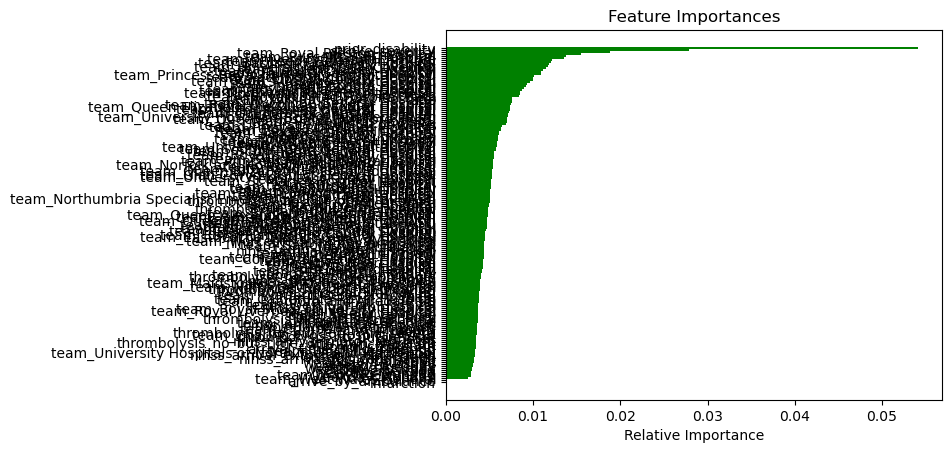

In [110]:
importances = model.feature_importances_
indices = np.argsort(importances)
features = train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

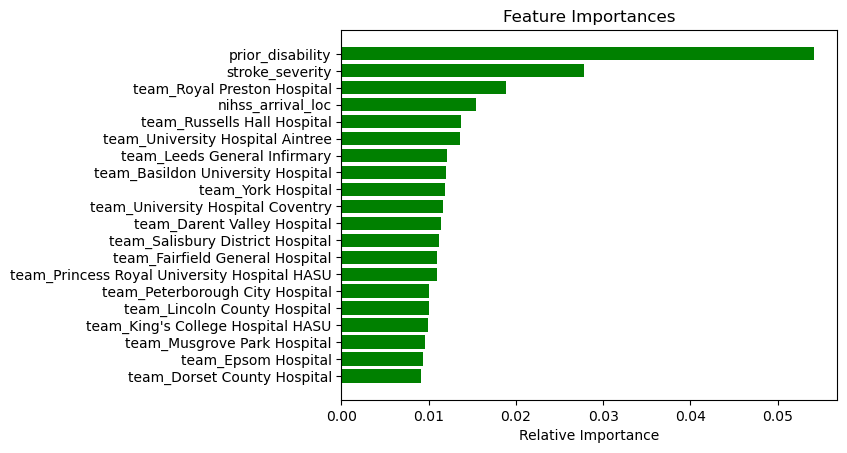

In [111]:
n_show = 20
importances = model.feature_importances_
indices = np.argsort(importances)
indices = indices[-n_show:]
features = train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Confusion matrix

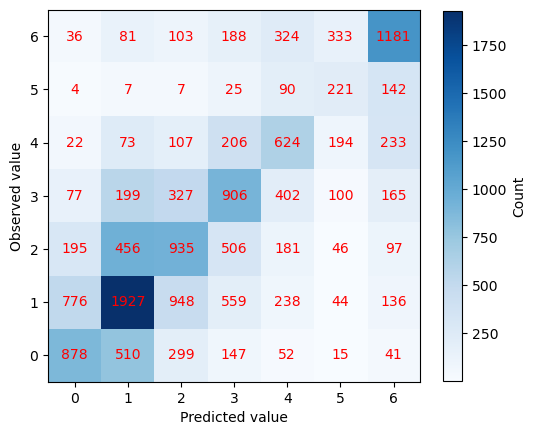

In [112]:
# Show confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix with colors
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(1,1,1)
heatmap = plt.imshow(cm, cmap=plt.cm.Blues, origin='lower')
colorbar = plt.colorbar(heatmap, shrink=0.8, ax=ax1, alpha=0.5, label='Count')

# To add values to plot
for i in range(len(cm)):
    for j in range(len(cm[0])):
        plt.text(i, j, cm[i][j], ha='center', va='center', color='r')

ax1.set_xlabel('Predicted value')
ax1.set_ylabel('Observed value')
plt.show()

Unbalanced dataset that gives low number of examples of class 5 to learn from.

In [113]:
y_test.value_counts().sort_index()

0.0    1988
1.0    3253
2.0    2726
3.0    2537
4.0    1911
5.0     953
6.0    1995
Name: discharge_disability, dtype: int64

SHAP Summary Plot

SHAP values of a model’s output explain how features impact the output of the model.

Creates a list of 7 numpy arrays (each array of size (n_instances, n_features)).
len(shap_values) = 7
shap_values[0].shape = (15363, 168)
shap_values[1].shape = (15363, 168)
shap_values[2].shape = (15363, 168)
shap_values[3].shape = (15363, 168)
shap_values[4].shape = (15363, 168)
shap_values[5].shape = (15363, 168)
shap_values[6].shape = (15363, 168)


In [172]:
# compute SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

In [173]:
base_values = explainer.expected_value
#data_values = explainer.data(X_test)

In [177]:
base_values

[0.36548066,
 0.89415,
 0.7494681,
 0.6570115,
 0.36580068,
 -0.34309745,
 0.33268344]

Numpy array 3D
shap_values1.shape = (15366, 168, 7)

In [122]:
# Set up explainer using the model and feature values from training set
explainer1 = shap.TreeExplainer(model, X_train)
# Get (and store) Shapley values along with base and feature values
shap_values_extended1 = explainer1(X_test)
# Shap values exist for each classification in a Tree
shap_values1 = shap_values_extended1.values

100%|===================| 107538/107541 [26:35<00:00]        

In [178]:
base_values1 = shap_values_extended1.base_values

In [187]:
base_values1[0]

array([-0.75321218,  0.32243106,  0.41842815,  0.19451679, -0.2685679 ,
       -1.76524896, -0.63497487])

Compare the difference between the shap_values calculated without background data (in 3.5seconds) and the shap_values1 calculated with X_train as background data (26 minutes)

For each case, get the SHAP values for class 0 for all the instances, for all the features.

In [154]:
shap_values[0].shape

(15363, 168)

In [155]:
shap_values1[:,:,0].shape

(15363, 168)

Making the 3D numpy array (shap_values1) match the list of 7 arrays (shap_values) by creating shap_values1_list, so it can be used in the shap.summary_plot

In [211]:
shap_values1_list = []
for i in range(n_classes):
    shap_values1_list.append(shap_values1[:,:,i])

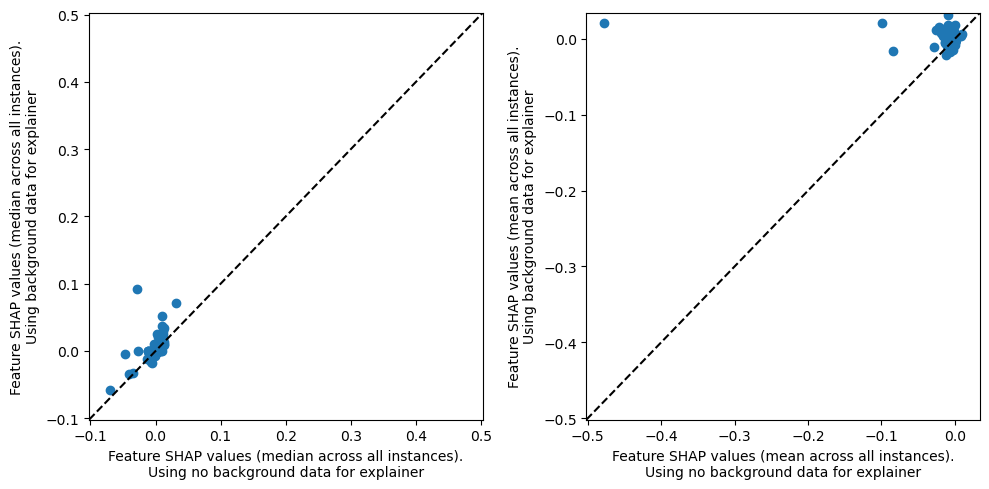

In [202]:
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,2,1)
x = np.median(shap_values[0], axis=0)
y = np.median(shap_values1[:,:,0], axis=0)
ax.set_xlabel("Feature SHAP values (median across all instances).\nUsing no background data for explainer")
ax.set_ylabel("Feature SHAP values (median across all instances).\nUsing background data for explainer")

ax = plt.scatter(x,y)

ax_min = min(plt.xlim()[0], plt.ylim()[0])
ax_max = min(plt.xlim()[1], plt.ylim()[1])
plt.xlim([ax_min, ax_max])
plt.ylim([ax_min, ax_max])
# Add 1:1 line
plt.plot([ax_min,ax_max],[ax_min,ax_max], color='k', linestyle ='--')

ax1 = fig.add_subplot(1,2,2)
x = np.mean(shap_values[0], axis=0)
y = np.mean(shap_values1[:,:,0], axis=0)
ax1.set_xlabel("Feature SHAP values (mean across all instances).\nUsing no background data for explainer")
ax1.set_ylabel("Feature SHAP values (mean across all instances).\nUsing background data for explainer")

ax1 = plt.scatter(x,y)

ax_min = min(plt.xlim()[0], plt.ylim()[0])
ax_max = min(plt.xlim()[1], plt.ylim()[1])
plt.xlim([ax_min, ax_max])
plt.ylim([ax_min, ax_max])
# Add 1:1 line
plt.plot([ax_min,ax_max],[ax_min,ax_max], color='k', linestyle ='--')

plt.tight_layout()

In case the classes are not matched up, see if there's a better fit between unmatches class order

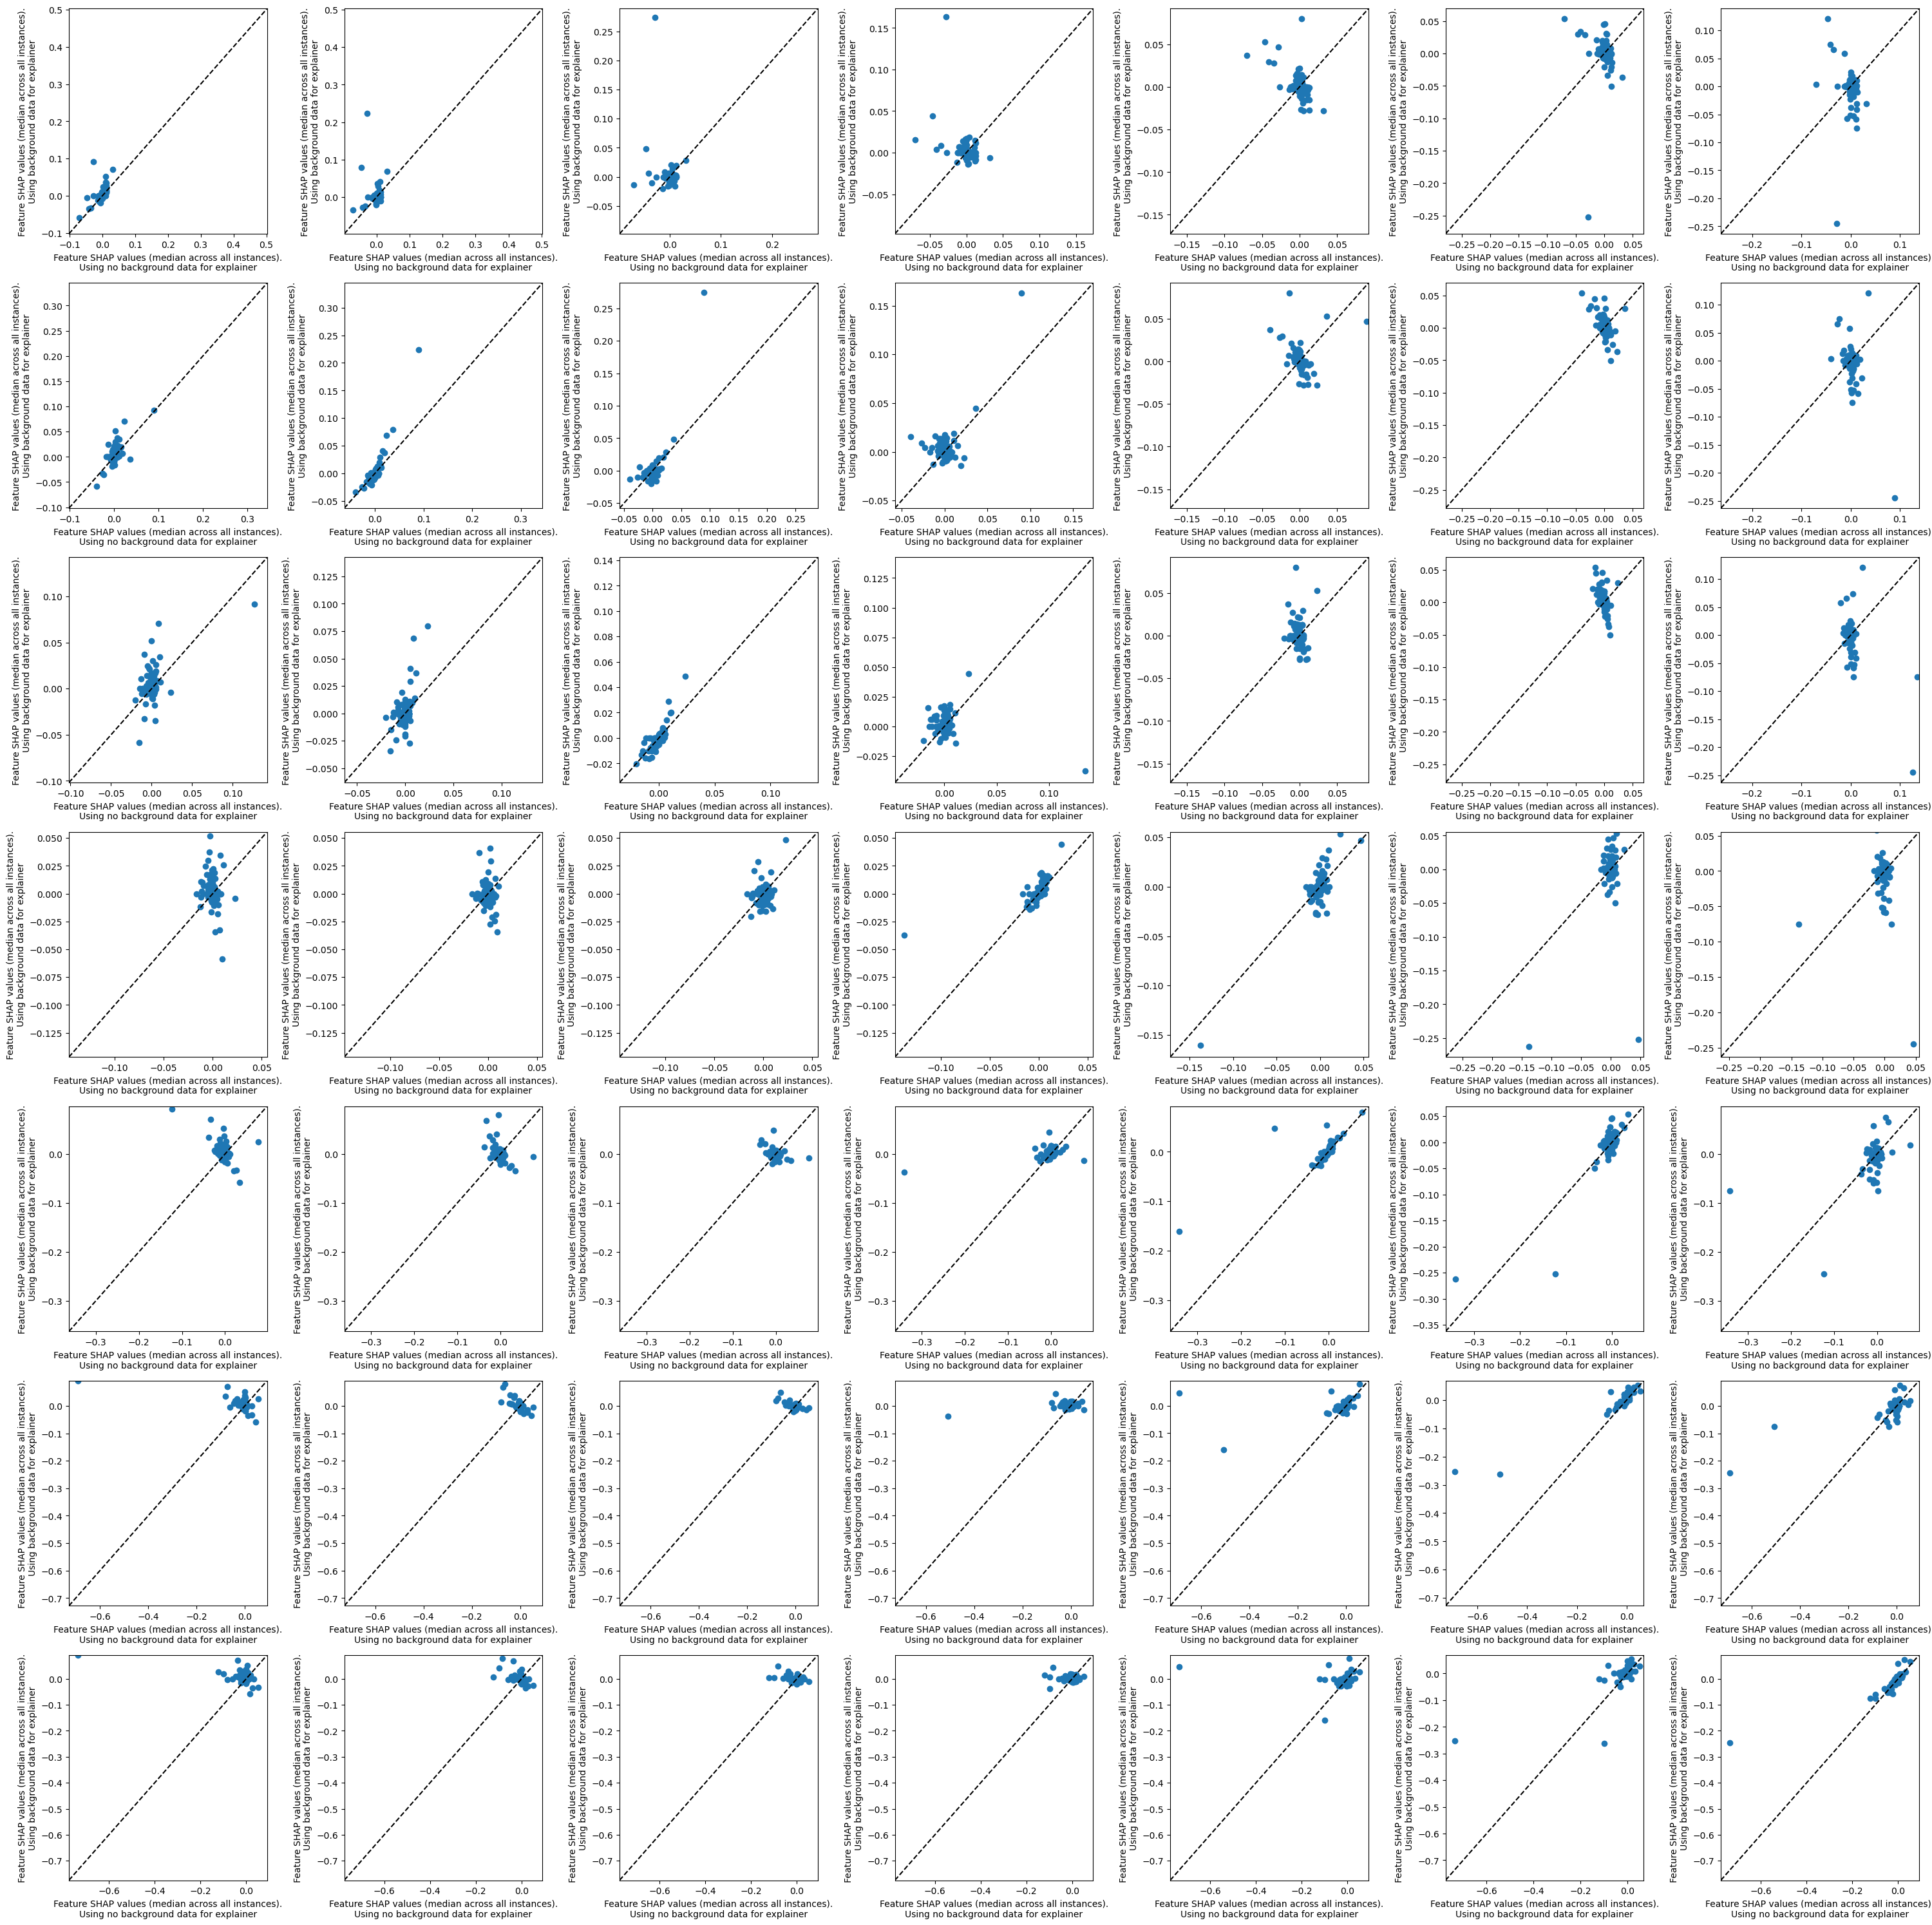

In [201]:
fig = plt.figure(figsize=(30,30))
c=0
for i in range(n_classes):
    for j in range(n_classes):
        c+=1
        ax = fig.add_subplot(n_classes,n_classes,c)
        x = np.median(shap_values[i], axis=0)
        y = np.median(shap_values1[:,:,j], axis=0)
        ax.set_xlabel("Feature SHAP values (median across all instances).\nUsing no background data for explainer")
        ax.set_ylabel("Feature SHAP values (median across all instances).\nUsing background data for explainer")

        ax = plt.scatter(x,y)

        ax_min = min(plt.xlim()[0], plt.ylim()[0])
        ax_max = min(plt.xlim()[1], plt.ylim()[1])
        plt.xlim([ax_min, ax_max])
        plt.ylim([ax_min, ax_max])
        # Add 1:1 line
        plt.plot([ax_min,ax_max],[ax_min,ax_max], color='k', linestyle ='--')

plt.tight_layout()

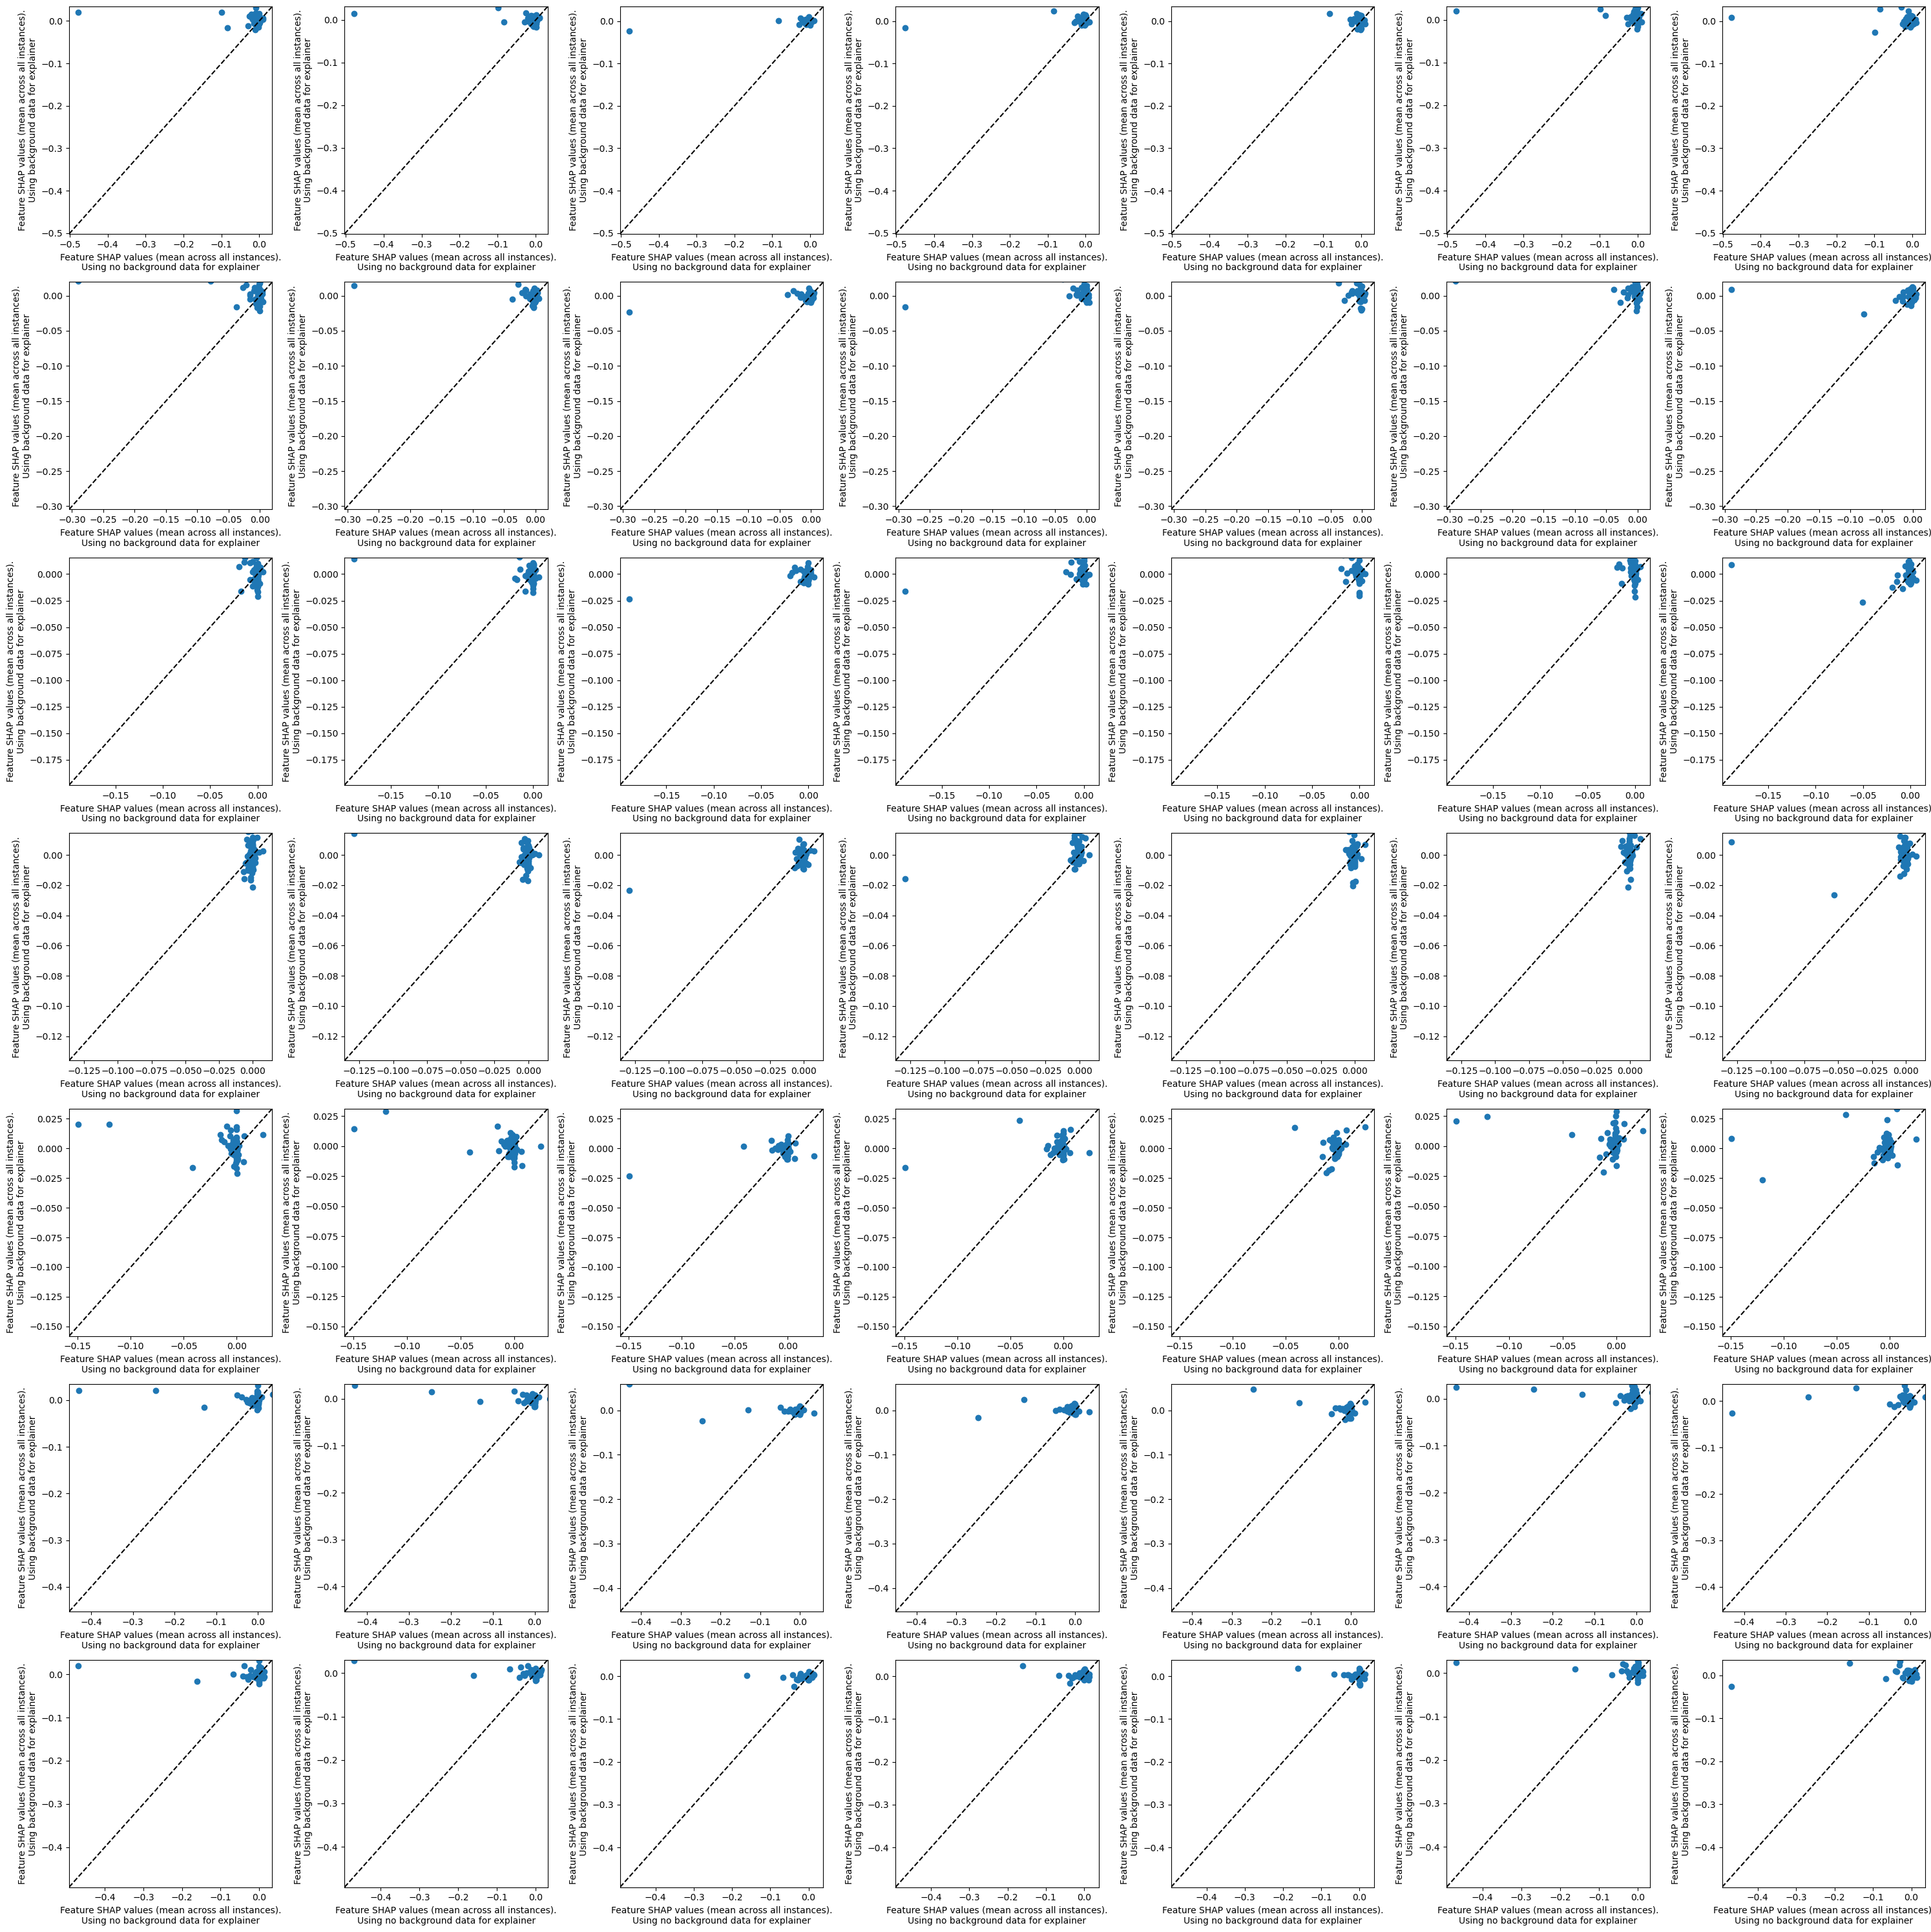

In [203]:
fig = plt.figure(figsize=(30,30))
c=0
for i in range(n_classes):
    for j in range(n_classes):
        c+=1
        ax = fig.add_subplot(n_classes,n_classes,c)
        x = np.mean(shap_values[i], axis=0)
        y = np.mean(shap_values1[:,:,j], axis=0)
        ax.set_xlabel("Feature SHAP values (mean across all instances).\nUsing no background data for explainer")
        ax.set_ylabel("Feature SHAP values (mean across all instances).\nUsing background data for explainer")

        ax = plt.scatter(x,y)

        ax_min = min(plt.xlim()[0], plt.ylim()[0])
        ax_max = min(plt.xlim()[1], plt.ylim()[1])
        plt.xlim([ax_min, ax_max])
        plt.ylim([ax_min, ax_max])
        # Add 1:1 line
        plt.plot([ax_min,ax_max],[ax_min,ax_max], color='k', linestyle ='--')

plt.tight_layout()

Now we can plot relevant plots that will help as analyze the model.

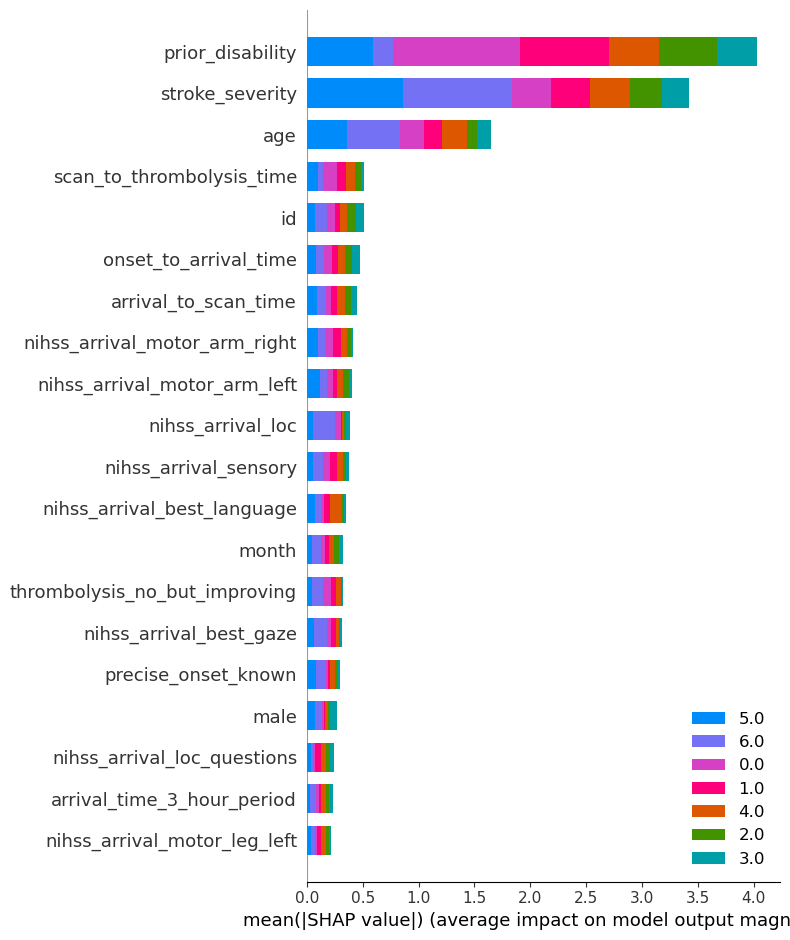

In [115]:
shap.summary_plot(shap_values, X_test.values, plot_type="bar", class_names=class_names, feature_names = X_test.columns)

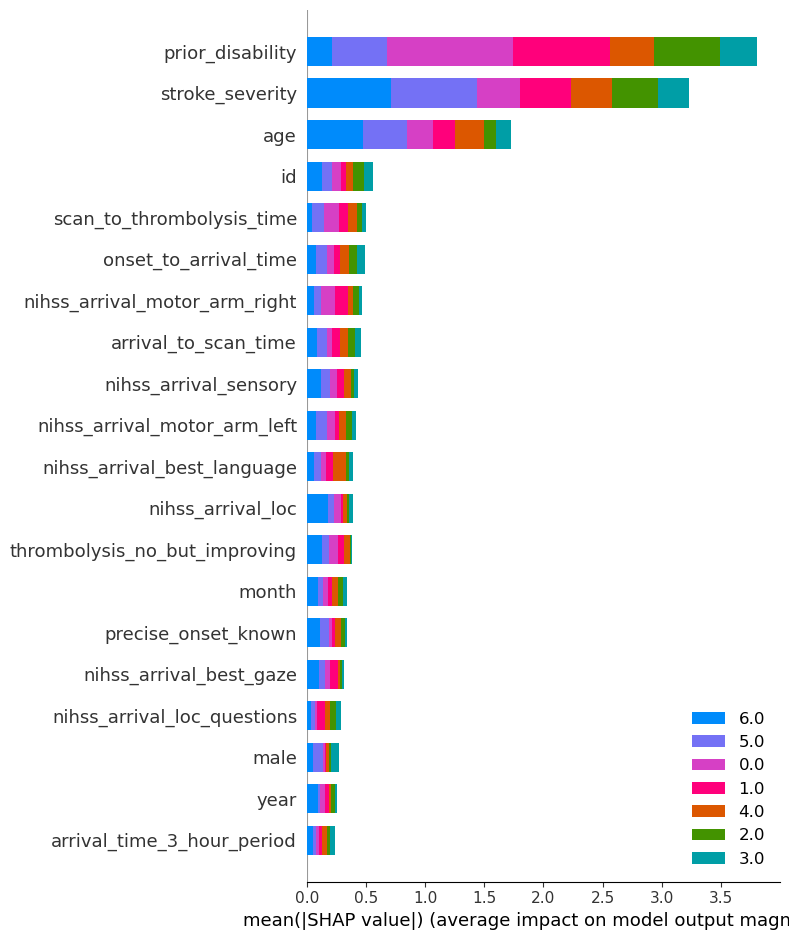

In [216]:
shap.summary_plot(shap_values1_list, X_test.values, plot_type="bar", class_names=class_names, feature_names = X_test.columns)

In this plot the impact of a feature on the classes are stacked to create the feature importance plot. Thus, if you created features in order to differentiate a particular class from the rest, that is the plot were you can see it. In other words summary plot for multiclass classification can show you what the machine managed to learn from the features. In the example below we can see that the class drop hardly uses the features Destination Plot, Source Port and Bytes Sent. We can also see the the classes allow and deny uses the same features equally. That is the reason the confusion between them is relatively high. In order to separate better between the allow and deny classes, one needs to generate new features that uniquely be dedicated towards this classes.

You can also see the summary_plot of a specific class.

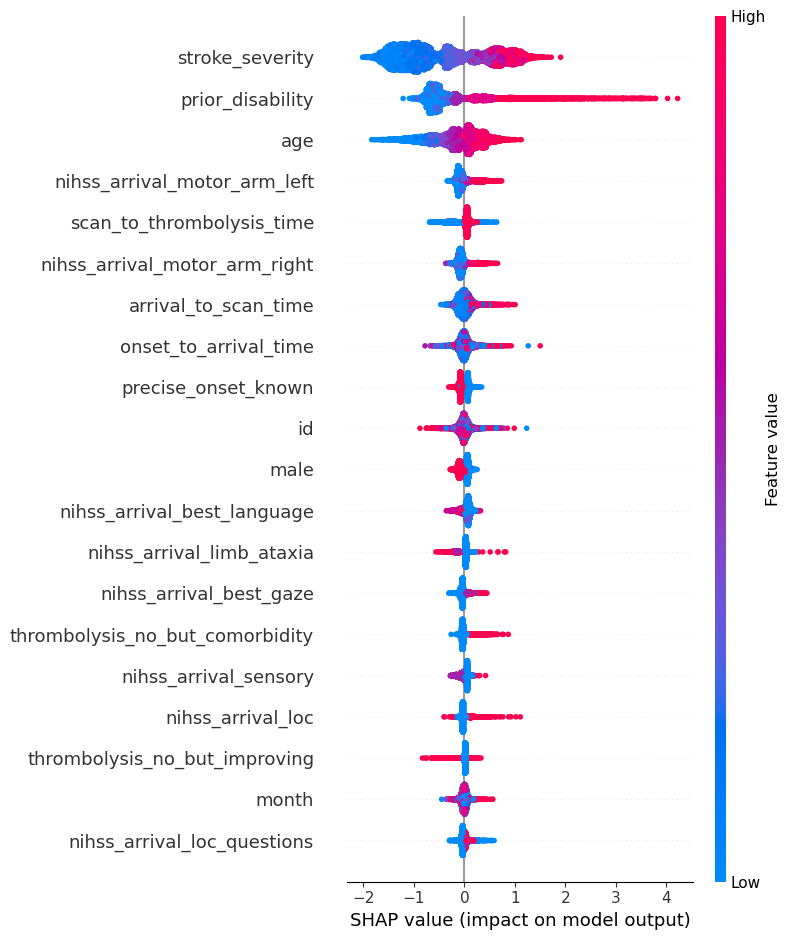

In [129]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,1,1)
ax = shap.summary_plot(shap_values[5], X_test.values, feature_names = X_test.columns, show=False)
#ax1 = fig.add_subplot(1,2,2)
#ax1 = shap.summary_plot(shap_values[0], X_test.values, feature_names = X_test.columns, show=False)



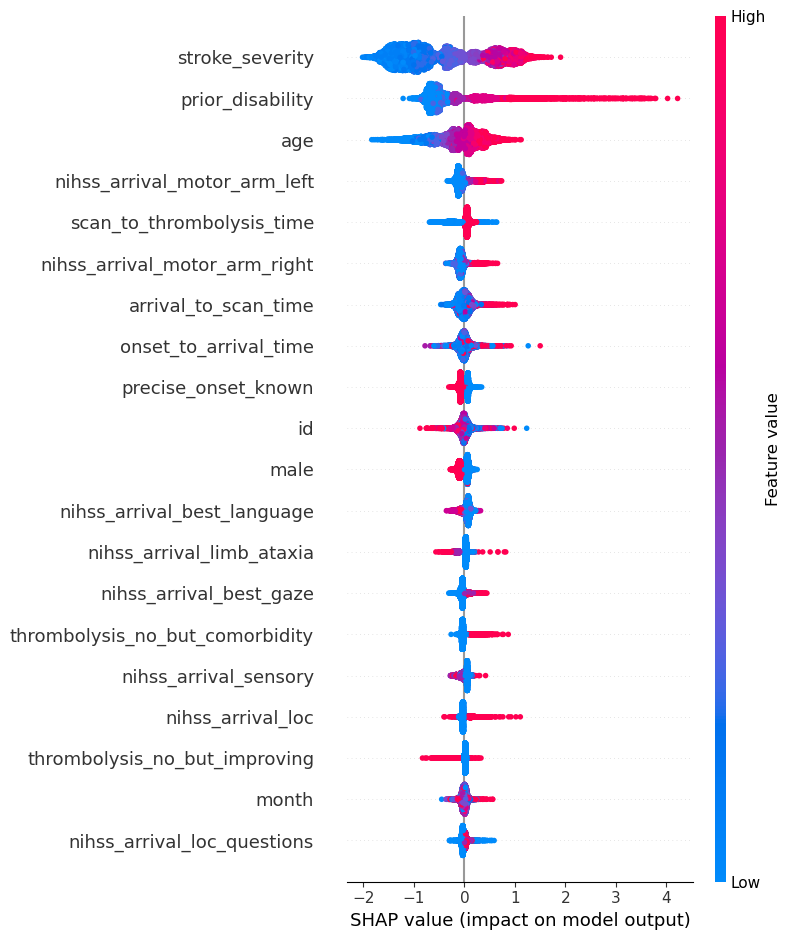

In [125]:
shap.summary_plot(shap_values[5], X_test.values, feature_names = X_test.columns)

The summary plot combines feature importance with feature effects. Each point on the summary plot is a Shapley value for a feature and an instance. The position on the y-axis is determined by the feature and on the x-axis by the Shapley value. You can see that the feature pkts_sent, being the least important feature, has low Shapley values. The color represents the value of the feature from low to high. Overlapping points are jittered in y-axis direction, so we get a sense of the distribution of the Shapley values per feature. The features are ordered according to their importance. In the summary plot, we see first indications of the relationship between the value of a feature and the impact on the prediction. But to see the exact form of the relationship, we have to look at SHAP dependence plots.

## SHAP Dependence Plot

The partial dependence plot (short PDP or PD plot) shows the marginal effect one or two features have on the predicted outcome of a machine learning model (J. H. Friedman 2001 [3]). A partial dependence plot can show whether the relationship between the target and a feature is linear, monotonic or more complex. The partial dependence plot is a global method: The method considers all instances and gives a statement about the global relationship of a feature with the predicted outcome. An assumption of the PDP is that the first feature are not correlated with the second feature. If this assumption is violated, the averages calculated for the partial dependence plot will include data points that are very unlikely or even impossible. A dependence plot is a scatter plot that shows the effect a single feature has on the predictions made by the model. In this example the property value increases significantly when the average number of rooms per dwelling is higher than 6. Each dot is a single prediction (row) from the dataset. The x-axis is the actual value from the dataset. The y-axis is the SHAP value for that feature, which represents how much knowing that feature’s value changes the output of the model for that sample’s prediction. The color corresponds to a second feature that may have an interaction effect with the feature we are plotting (by default this second feature is chosen automatically). If an interaction effect is present between this other feature and the feature we are plotting it will show up as a distinct vertical pattern of coloring.

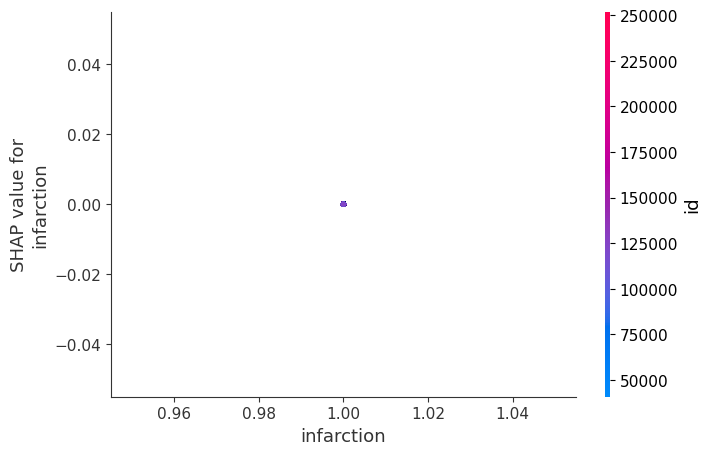

In [138]:
# If we pass a numpy array instead of a data frame then we
# need pass the feature names in separately
shap.dependence_plot(3, shap_values[0], X_test.values, feature_names=X_test.columns)

In the example above we can see a clear vertical pattern of coloring for the interaction between the features, Source Port and NAT Source Port.

## SHAP Force plot

Force plot gives us the explainability of a single model prediction. In this plot we can see how features contributed to the model’s prediction for a specific observation. It is very convenient to use for error analysis or for a deep understanding of a particular case.

In [118]:
row = 0

In [119]:
shap.force_plot(explainer.expected_value[0], shap_values[0][row], X_test.values[row], feature_names = X_test.columns)

From the plot we can see: The model predict_proba value: 0.79 The base value: this is the value that would be predicted if we didn’t know any features for the current instance. The base value is the average of the model output over training datatset (explainer.expected_value in the code). In this example base value = 0.5749 The numbers on the plot arrows are the value of the feature for this instance. Elapsed Time (sec)=5 and Packets = 1 Red representing features that pushed the model score higher, and blue representing features that pushed the score lower. The bigger the arrow, the bigger the impact of the feature on the output. The amount of decrease or increase in the impact can be seen in the x axis. Elapsed Time of 5 seconds increases the property that the class is allow, Packets of 6.546 reduces the property value.



## SHAP waterfall plot

Waterfall is another local analysis plot of a single instance prediction. Let’s take instance number 8 as an example:

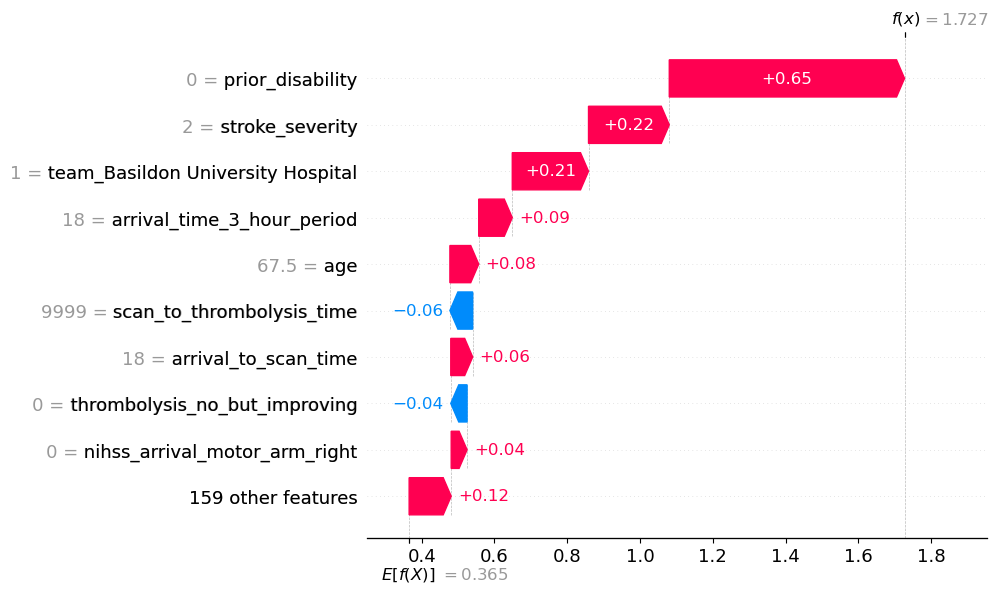

In [120]:
shap.waterfall_plot(shap.Explanation(values=shap_values[0][row], 
                                        base_values=explainer.expected_value[0], data=X_test.iloc[row],  
                                        feature_names=X_test.columns.tolist()))

f(x) is the model predict_proba value: 0.79. E[f(x)] is the base value = 0.5749. On the left are the features value and on the arrows the feature contribution to the prediction. Each row shows how the positive (red) or negative (blue) contribution of each feature moves the value from the expected model output over the background dataset to the model output for this prediction [2].

Summary
The SHAP framework has proved to be an important advancement in the field of machine learning model interpretation. SHAP combines several existing methods to create an intuitive, theoretically sound approach to explain predictions for any model. SHAP values quantify the magnitude and direction (positive or negative) of a feature’s effect on a prediction[6]. I believe XAI analysis with SHAP and other tools should be an integral part of the machine learning pipeline.

In [121]:
end_time = time.time()

print(f'Time taken: {end_time - start_time}')

Time taken: 16.779496908187866
